In [1]:
import numpy as np 
#import matplotlib as mp
#import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers.python.layers import batch_norm
#from skimage import img_as_float, img_as_uint
from skimage import io
from IPython.display import clear_output
%matplotlib inline

In [2]:
data = None
mean_img = None

# Hyper Params
PATCH_DIM = 31
BATCH_SIZE = 1
LEARNING_RATE = 5e-4
KEEP_PROB = 0.6
NUM_CLASSES = 2
FCHU1 = 256               # Fully connected layer 1 hidden units
MODEL_NAME = '19'
MODEL_PATH = '../../Data/models/model19/model.ckpt-5399'

In [3]:
def batch_norm_layer(x,train_phase,scope_bn):
    """Adds a Batch Normalization layer from http://arxiv.org/abs/1502.03167.
        "Batch Normalization: Accelerating Deep Network Training by Reducing
        Internal Covariate Shift"
        Sergey Ioffe, Christian Szegedy
      Can be used as a normalizer function for conv2d and fully_connected.
    """
    
    bn_train = batch_norm(x, decay=0.999, center=True, scale=True, updates_collections=None,
    is_training=True, reuse=None, # is this right?
    trainable=True, scope=scope_bn)
    
    bn_inference = batch_norm(x, decay=0.999, center=True, scale=True, updates_collections=None,
    is_training=False, reuse=True, # is this right?
    trainable=True, scope=scope_bn)
    
    z = tf.cond(train_phase, lambda: bn_train, lambda: bn_inference)
    return z


In [4]:
def placeholder_inputs(batch_size):
    """Generate placeholder variables to represent the input tensors.
    
    These placeholders are used as inputs by the rest of the model building
    code and will be fed from the downloaded data in the .run() loop, below.
    Args:
        batch_size: The batch size will be baked into both placeholders.
    Returns:
        images_placeholder: Images placeholder.
        labels_placeholder: Labels placeholder.
    """
    # Note that the shapes of the placeholders match the shapes of the full
    # image and label tensors, except the first dimension is now batch_size
    # rather than the full size of the train or test data sets.
    images_placeholder = tf.placeholder(tf.float32, shape=(batch_size, PATCH_DIM**2*3))
    labels_placeholder = tf.placeholder(tf.int32, shape=(batch_size, NUM_CLASSES))
    return images_placeholder, labels_placeholder

In [5]:
#data = pd.read_pickle('../../Data/mean_normalised_df_no_class_bias.pkl') 
#mean_img = pd.read_pickle('../../Data/mean_img_no_class_bias.pkl')

    

images, labels_placeholder = placeholder_inputs(BATCH_SIZE)
keep_prob = tf.placeholder(tf.float32)
train_phase = tf.placeholder(tf.bool)

In [6]:
#---------------------------Inference------------------------------------
layers = dict()
with tf.variable_scope('h_conv1') as scope:
        weights = tf.get_variable('weights', shape=[4, 4, 3, 64], 
                                  initializer=tf.contrib.layers.xavier_initializer_conv2d())
        biases = tf.get_variable('biases', shape=[64], initializer=tf.constant_initializer(0.05))
        
        x_image = tf.reshape(images, [-1,PATCH_DIM,PATCH_DIM,3])
        x_image_bn = batch_norm_layer(x_image, train_phase, scope.name)
        h_conv1_z = tf.nn.conv2d(x_image_bn, weights, strides=[1, 1, 1, 1], padding='VALID') + biases
        h_conv1 = tf.nn.relu(h_conv1_z, name=scope.name)
        layers['h_conv1'] = h_conv1_z
        
with tf.variable_scope('h_conv2') as scope:
        weights = tf.get_variable('weights', shape=[4, 4, 64, 64], 
                                  initializer=tf.contrib.layers.xavier_initializer_conv2d())
        biases = tf.get_variable('biases', shape=[64], initializer=tf.constant_initializer(0.05))
        h_conv1_bn = batch_norm_layer(h_conv1, train_phase, scope.name)
        h_conv2_z = tf.nn.conv2d(h_conv1_bn, weights, strides=[1, 1, 1, 1], padding='SAME')+biases
        h_conv2 = tf.nn.relu(h_conv2_z, name=scope.name)
        layers['h_conv2'] = h_conv2_z
    
h_pool1 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME', name='h_pool1')
    
with tf.variable_scope('h_conv3') as scope:
        weights = tf.get_variable('weights', shape=[4, 4, 64, 64], 
                                  initializer=tf.contrib.layers.xavier_initializer_conv2d())
        biases = tf.get_variable('biases', shape=[64], initializer=tf.constant_initializer(0.05))
        h_pool1_bn = batch_norm_layer(h_pool1, train_phase, scope.name)
        h_conv3_z = tf.nn.conv2d(h_pool1_bn, weights, strides=[1, 1, 1, 1], padding='SAME')+biases
        h_conv3 = tf.nn.relu(h_conv3_z, name=scope.name)
        layers['h_conv3'] = h_conv3_z
        
h_pool2 = tf.nn.max_pool(h_conv3, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME', name='h_pool2')    
    
with tf.variable_scope('h_fc1') as scope:
        weights = tf.get_variable('weights', shape=[7**2*64, FCHU1], 
                                  initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.get_variable('biases', shape=[FCHU1], initializer=tf.constant_initializer(0.05))
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        #h_pool2_flat_bn = batch_norm_layer(h_pool2_flat, train_phase, scope.name)
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, weights) + biases, name = 'h_fc1')
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
        
with tf.variable_scope('h_fc2') as scope:
        weights = tf.get_variable('weights', shape=[FCHU1, NUM_CLASSES], 
                                  initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.get_variable('biases', shape=[NUM_CLASSES])
        #h_fc1_drop_bn = batch_norm_layer(h_fc1, train_phase, scope.name)
        logits = (tf.matmul(h_fc1_drop, weights) + biases)
#--------------------------------------------------------------------------------
        

In [7]:
saver = tf.train.Saver()

# Create a session for running Ops on the Graph.
sess = tf.Session()
saver.restore(sess, MODEL_PATH)


In [8]:
layer = 'h_conv1'
channel = 5
img_noise = np.random.uniform(size=(31,31,3)) + 100.0

In [9]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    a = np.reshape(a, [31,31,3])
    io.imshow(a)
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return ((a-a.mean())/(a.std()+1e-5))*s + 0.5

In [10]:
def T(layer):
    '''Helper for getting layer output tensor'''
    return layers[layer]

In [13]:
def render_naive(t_obj, img0=img_noise, iter_n=2, step=0.1):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, images)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    img = [img]
    img = np.reshape(img, [1,2883])
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {images:img, keep_prob:1.0, train_phase: False})
        print g.max()
        print g.min()
        print g.std()
        print g.mean()
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-5         # for different layers and networks
        
        img += g*step
        print score
        #clear_output()
        showarray(visstd(img))

nan
nan
nan
nan
0.846883
nan
nan
nan
nan
nan


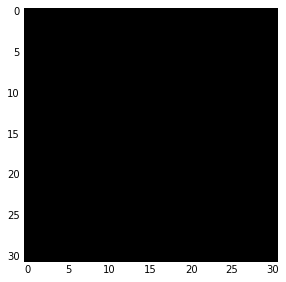

In [14]:
render_naive(T(layer)[:,:,:,channel])